# Collaboration and Competition

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


### Benchmark model

First a benchmark model is implemented. Therefore the multi agent problem is reformulated into a single DDPG problem and more or less the code from the policy gradient continuous control problem is used. 
There is only one policy which receives both state vectors and outputs the actions of both agents. Also the critic receives both states and the actions of both actors.

Due to the small state space size $48=2*24$ and the small action size rather simple networks with two hidden layers are used.
Both have relu activation functions and a final output layer with tanh activation for the actor and linear activation for the critic network.
The actor network consists of 128 and 64 neurons in the first and second hidden layer, while the critic network 128 neurons in each hidden layer.

The following paramters are used:

- $\gamma$: Discount factor during the computation of the target $(target = reward + gamma*Qvalue(state_{t+1}, action_{t+1}))$.
- $\tau$, update_every: $\tau$ is a float value used to compute the convex combination of old Q-network's and target Q-network's weights. The weights are updated every update_every steps to stabilize the learning process.
- $lr_{actor}, lr_{critic}$: Learning rates for the optimizer of the Q-network and the Policy network.


In order to explore the environment Gaussian noise is added to the agent's actions. The standard deviation $\sigma$ of the agent starts with a value of $1.0$ and then decreases to $0.05$ via $\sigma * 0.999^{iter}$.

In [5]:
BUFFER_SIZE = 10000  # replay buffer size
BATCH_SIZE = 16        # minibatch size
GAMMA = 0.98            # discount factor
TAU = 5e-4              # for soft update of target parameters
LR_ACTOR = 1e-4       # learning rate of the actor 
LR_CRITIC = 1e-4       # learning rate of the critic

In [6]:
class environment_single_wrapper():
    def __init__(self, env):
        self.env = env
        self.vector_observations = self.env
        self.brain_names = self.env.brain_names
        
    def reset(self, train_mode):
        self.env_info = self.env.reset(train_mode)
        return self
    
    def __getitem__(self, brain_name):
        self.env_info = self.env_info[brain_name]
        self.vector_observations = self.env_info.vector_observations.reshape(1,-1)
        self.rewards = np.array([sum(self.env_info.rewards)]).reshape(1,-1)
        self.local_done = np.array([max(self.env_info.local_done)]).reshape(1,-1)
        return self
    
    def step(self, action):
        self.env_info = self.env.step(action)
        return self

In [7]:
from pi_network import PiNetwork
from q_network import QNetwork

actor = PiNetwork(input_size=state_size*2, output_size=action_size*2, layer_size1=128, layer_size2=64, lr=LR_ACTOR)
critic = QNetwork(input_size=state_size*2+action_size*2, layer_size1=128, layer_size2=128, lr=LR_CRITIC)

from agent import  DeterministicActorCriticAgent
from noise import OUNoise, GaussianNoise
from replay_buffer import ReplayBuffer
from trainer import Trainer


memory = ReplayBuffer(state_size, BUFFER_SIZE , BATCH_SIZE, 1337)
noise = GaussianNoise(action_size*2, 1, 1337, sigma=1.0, sigma_decay=0.999, sigma_min=0.025)
ac =  DeterministicActorCriticAgent(gamma=GAMMA, tau=TAU, batch_size=BATCH_SIZE, update_every=1,
                                    actor=actor, critic=critic, memory=memory, noise=noise)

trainer = Trainer(environment_single_wrapper(env), ac)

In [8]:
scores = trainer.train(8000)

Episode 0	Average Score: -0.01
Episode 1	Average Score: 0.04

E:\github\multi_agent_ddpg\agent.py:123: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 100	Average Score: -0.01
Episode 200	Average Score: -0.00
Episode 300	Average Score: -0.01
Episode 400	Average Score: -0.01
Episode 500	Average Score: -0.00
Episode 600	Average Score: 0.000
Episode 700	Average Score: -0.00
Episode 800	Average Score: -0.01
Episode 900	Average Score: 0.010
Episode 1000	Average Score: 0.02
Episode 1100	Average Score: 0.010
Episode 1200	Average Score: -0.01
Episode 1300	Average Score: 0.001
Episode 1400	Average Score: 0.010
Episode 1500	Average Score: 0.010
Episode 1600	Average Score: -0.00
Episode 1700	Average Score: 0.060
Episode 1800	Average Score: 0.05
Episode 1900	Average Score: -0.00
Episode 2000	Average Score: 0.041
Episode 2100	Average Score: 0.020
Episode 2200	Average Score: -0.00
Episode 2300	Average Score: 0.020
Episode 2400	Average Score: 0.010
Episode 2500	Average Score: 0.001
Episode 2600	Average Score: 0.030
Episode 2700	Average Score: 0.04
Episode 2800	Average Score: 0.06
Episode 2900	Average Score: 0.01
Episode 3000	Average Score: 

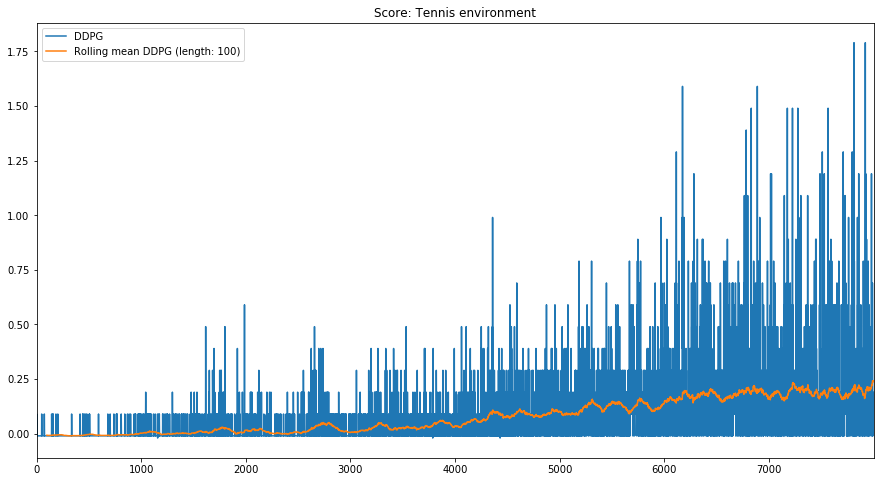

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd


plt.figure(figsize=(15,8))
pd.Series(scores, name='DDPG').plot()
pd.Series(scores, name='Rolling mean DDPG (length: 100)').rolling(100).mean().plot()
plt.title('Score: Tennis environment')
plt.legend()

In [10]:
import torch
actor = trainer.agent.actor_local

#path = './coop_policy_network_tennis'
#actor = trainer.agent.actor_local.state_dict()
#torch.save(trainer.agent.actor_local.state_dict(), path)

#actor = PiNetwork(input_size=state_size*2, output_size=action_size*2, layer_size1=128, layer_size2=64, lr=LR_ACTOR)
#actor.load_state_dict(torch.load(path))
#actor.eval()

In [11]:
env_wrapped = environment_single_wrapper(env)

In [12]:
scores = []
for i in range(1, 100):                                      # play game for 5 episodes
    env_info = env_wrapped.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    score = []                  # initialize the score (for each agent)
    while True:
        actions = actor(torch.from_numpy(states).float()).cpu().data.numpy()
        env_info = env_wrapped.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        score.append(env_info.rewards)                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break

    max_score_in_episode = np.max((np.sum(np.array(score).reshape(-1, len(env_info.rewards)), axis=0)))
    scores.append(max_score_in_episode)
    print('Score (max over agents) from episode {}: {}'.format(i, max_score_in_episode))

print('Mean score over all episodes {}'.format(np.mean(scores)))

Score (max over agents) from episode 1: 0.8900000136345625
Score (max over agents) from episode 2: 0.09000000171363354
Score (max over agents) from episode 3: 5.000000074505806
Score (max over agents) from episode 4: 2.890000043436885
Score (max over agents) from episode 5: 0.09000000171363354
Score (max over agents) from episode 6: 0.09000000171363354
Score (max over agents) from episode 7: 5.100000075995922
Score (max over agents) from episode 8: 2.090000031515956
Score (max over agents) from episode 9: 1.8900000285357237
Score (max over agents) from episode 10: 1.7900000289082527
Score (max over agents) from episode 11: 1.1900000181049109
Score (max over agents) from episode 12: 0.3900000061839819
Score (max over agents) from episode 13: 4.2900000642985106
Score (max over agents) from episode 14: 0.09000000171363354
Score (max over agents) from episode 15: 5.000000074505806
Score (max over agents) from episode 16: 0.2900000046938658
Score (max over agents) from episode 17: 0.5900000

In [13]:
scores = []
for i in range(1, 3):                                      # play game for 5 episodes
    env_info = env_wrapped.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    score = []                  # initialize the score (for each agent)
    while True:
        actions = actor(torch.from_numpy(states).float()).cpu().data.numpy()
        env_info = env_wrapped.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        score.append(env_info.rewards)                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break

    max_score_in_episode = np.max((np.sum(np.array(score).reshape(-1, len(env_info.rewards)), axis=0)))
    scores.append(max_score_in_episode)
    print('Score (max over agents) from episode {}: {}'.format(i, max_score_in_episode))

print('Mean score over all episodes {}'.format(np.mean(scores)))

Score (max over agents) from episode 1: 3.2900000493973494
Score (max over agents) from episode 2: 0.8900000136345625
Mean score over all episodes 2.090000031515956


## Multi agent

In the previous version only one network controlled the actions of both actions. In the following a more natural approach shall be taken, where each action is controlled by one network and the network only receives its own states, which makes it for the actor more difficult, but more realistic.

Each actor network receives only the actor's state and outputs his corresponding action. Two Q-Networks are trained, where each network receives all states and actions. The only difference lies in the temporal difference target, where the i-th actor reward is used. Here all actions are taken into account to make the environment stationary. If the Q-Network would only receive one policy the environment would become non-stationary from the perspective of the agent.

Compared to the benchmark model above the state and action space size is reduced and hence a slightly smaller network with 64 neurons in both hidden layers is used. The critic network structure remains the same.

The other parameters remain unchanged:

In [5]:
BUFFER_SIZE = 10000  # replay buffer size
BATCH_SIZE = 16        # minibatch size
GAMMA = 0.98            # discount factor
TAU = 5e-4              # for soft update of target parameters
LR_ACTOR = 1e-4       # learning rate of the actor 
LR_CRITIC = 1e-4       # learning rate of the critic

In [6]:
from pi_network import PiNetwork
from q_network import QNetwork

actor1 = PiNetwork(input_size=state_size, output_size=action_size, layer_size1=64, layer_size2=64, lr=LR_ACTOR)
actor2 = PiNetwork(input_size=state_size, output_size=action_size, layer_size1=64, layer_size2=64, lr=LR_ACTOR)
critic1 = QNetwork(input_size=state_size*2+action_size*2, layer_size1=128, layer_size2=128, lr=LR_CRITIC)
critic2 = QNetwork(input_size=state_size*2+action_size*2, layer_size1=128, layer_size2=128, lr=LR_CRITIC)

from agent import  MultiAgentDeterministicActorCriticAgent
from noise import OUNoise, GaussianNoise
from replay_buffer import ReplayBuffer
from trainer import Trainer


memory = ReplayBuffer(state_size, BUFFER_SIZE , BATCH_SIZE, 1337)
#noise = OUNoise(action_size*2, 1, 1337, sigma_decay=0.999, sigma=0.5, sigma_min=0.025)
noise = GaussianNoise(action_size, 2, 1337, sigma=1.0, sigma_decay=0.999, sigma_min=0.025)
ac =  MultiAgentDeterministicActorCriticAgent(gamma=GAMMA, tau=TAU, batch_size=BATCH_SIZE, update_every=1,
                                    actors=[actor1, actor2], critics=[critic1, critic2], memory=memory, noise=noise)

trainer = Trainer(env, ac)

In [7]:
scores = trainer.train(10000)

Episode 0	Average Score: 0.00
Episode 1	Average Score: 0.00

E:\github\multi_agent_ddpg\agent.py:268: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(critic_local.parameters(), 1)


Episode 100	Average Score: 0.00
Episode 200	Average Score: 0.01
Episode 300	Average Score: 0.00
Episode 400	Average Score: 0.00
Episode 500	Average Score: 0.00
Episode 600	Average Score: 0.01
Episode 700	Average Score: 0.02
Episode 800	Average Score: 0.00
Episode 900	Average Score: 0.00
Episode 1000	Average Score: 0.00
Episode 1100	Average Score: 0.00
Episode 1200	Average Score: 0.00
Episode 1300	Average Score: 0.01
Episode 1400	Average Score: 0.00
Episode 1500	Average Score: 0.01
Episode 1600	Average Score: 0.00
Episode 1700	Average Score: 0.00
Episode 1800	Average Score: 0.00
Episode 1900	Average Score: 0.00
Episode 2000	Average Score: 0.01
Episode 2100	Average Score: 0.05
Episode 2200	Average Score: 0.04
Episode 2300	Average Score: 0.04
Episode 2400	Average Score: 0.02
Episode 2500	Average Score: 0.01
Episode 2600	Average Score: 0.02
Episode 2700	Average Score: 0.03
Episode 2800	Average Score: 0.03
Episode 2900	Average Score: 0.01
Episode 3000	Average Score: 0.03
Episode 3100	Averag

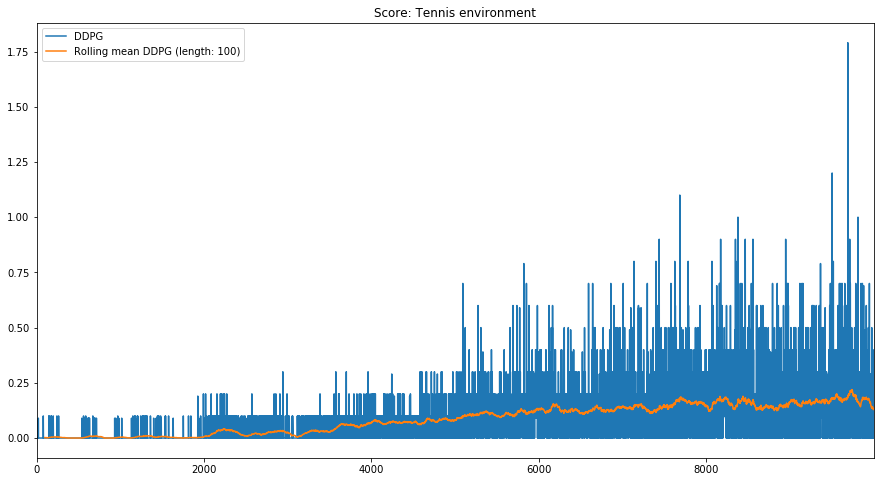

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd


plt.figure(figsize=(15,8))
pd.Series(scores, name='DDPG').plot()
pd.Series(scores, name='Rolling mean DDPG (length: 100)').rolling(100).mean().plot()
plt.title('Score: Tennis environment')
plt.legend()

In [15]:
import torch
#actor1 = trainer.agent.actors_local[0]
#actor2 = trainer.agent.actors_local[1]

#path = './coop_policy_network_tennis'
#torch.save(actor1.state_dict(), './actor1_policy_network_tennis')
#torch.save(actor2.state_dict(), './actor21_policy_network_tennis')

actor1 = PiNetwork(input_size=state_size, output_size=action_size, layer_size1=64, layer_size2=64, lr=LR_ACTOR)
actor1.load_state_dict(torch.load('./actor1_policy_network_tennis'))
actor1.eval()

actor2 = PiNetwork(input_size=state_size, output_size=action_size, layer_size1=64, layer_size2=64, lr=LR_ACTOR)
actor2.load_state_dict(torch.load( './actor1_policy_network_tennis'))
actor2.eval()

PiNetwork(
  (model): Sequential(
    (fc1): Linear(in_features=24, out_features=64, bias=True)
    (relu1): ReLU()
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (relu2): ReLU()
    (logits): Linear(in_features=64, out_features=2, bias=True)
    (tanh): Tanh()
  )
)

In [16]:
scores = []
for i in range(1, 100):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    score = []                  # initialize the score (for each agent)
    while True:
        action1 = actor1(torch.from_numpy(states[0]).float()).cpu().data.numpy()
        action2 = actor2(torch.from_numpy(states[1]).float()).cpu().data.numpy()
        env_info = env.step(np.concatenate((action1, action2), axis=1))[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        score.append(env_info.rewards)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    max_score_in_episode = np.max((np.sum(np.array(score).reshape(-1, len(env_info.rewards)), axis=0)))
    scores.append(max_score_in_episode)

    print('Score (max over agents) from episode {}: {}'.format(i,max_score_in_episode))

print('Mean score over all episodes {}'.format(np.mean(scores)))

Score (max over agents) from episode 1: 0.9000000134110451
Score (max over agents) from episode 2: 0.4000000059604645
Score (max over agents) from episode 3: 0.4000000059604645
Score (max over agents) from episode 4: 0.6000000089406967
Score (max over agents) from episode 5: 1.700000025331974
Score (max over agents) from episode 6: 0.9000000134110451
Score (max over agents) from episode 7: 0.4000000059604645
Score (max over agents) from episode 8: 0.5000000074505806
Score (max over agents) from episode 9: 0.800000011920929
Score (max over agents) from episode 10: 1.0000000149011612
Score (max over agents) from episode 11: 0.5000000074505806
Score (max over agents) from episode 12: 0.4000000059604645
Score (max over agents) from episode 13: 0.4000000059604645
Score (max over agents) from episode 14: 0.20000000298023224
Score (max over agents) from episode 15: 0.5000000074505806
Score (max over agents) from episode 16: 1.5000000223517418
Score (max over agents) from episode 17: 0.5000000

In [17]:
scores = []
for i in range(1, 3):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    score = []                  # initialize the score (for each agent)
    while True:
        action1 = actor1(torch.from_numpy(states[0]).float()).cpu().data.numpy()
        action2 = actor2(torch.from_numpy(states[1]).float()).cpu().data.numpy()
        env_info = env.step(np.concatenate((action1, action2),axis=1))[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        score.append(env_info.rewards)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    max_score_in_episode = np.max((np.sum(np.array(score).reshape(-1, len(env_info.rewards)), axis=0)))
    scores.append(max_score_in_episode)

    print('Score (max over agents) from episode {}: {}'.format(i,max_score_in_episode))

print('Mean score over all episodes {}'.format(np.mean(scores)))

Score (max over agents) from episode 1: 0.7000000104308128
Score (max over agents) from episode 2: 0.5000000074505806
Mean score over all episodes 0.6000000089406967
